In [1]:
import io
import sys
import numpy as np
import pandas as pd
from copy import deepcopy
from itertools import product
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import matplotlib.colors as mcolors

In [2]:
home_dir = '/Users/trungpq/Workspace/dev/clabsi/'

## Data

The result in this notebook is a bit different to our UAI submission because we found and fixed a bug in the data pre-processing part.

In [3]:
df = pd.read_csv(home_dir + "processed_data/clean_202406121003_PatientData.csv")
col_names = ['EPIC', 'CRISP', 'NHSN_CLABSI', 'Peds', 'Chemotherapy', 'OPAT', 'TPN', 'OtherTherapy', 'Port', 'PICC', 'TunneledCVC']
df = df.loc[:, col_names]

In [4]:
# composite proxy
df['EPIC_or_CRISP'] = ((df['EPIC'] + df['CRISP']) > 0).astype(int)

In [5]:
# ZAR graph: R <- C -> X(1) -> X <- R -> W
X = 'NHSN_CLABSI'          # Observed proxy of the zero-inflated variable
W = 'EPIC'
# W = 'CRISP'
# W = 'EPIC_or_CRISP'        # Inflation indicator's proxy
C = ['Peds', 'Chemotherapy', 'OPAT', 'TPN', 'OtherTherapy', 'Port', 'PICC', 'TunneledCVC']    # Observed covariates

# File name to save result
file_name = (
    f'202406271433-{W.lower()}'
)

In [6]:
observed_rate = df.NHSN_CLABSI.mean()

## Empirical distribution

In [7]:
def fix_div_by_zero(p):
    p = p + 1E-20
    p = p / np.sum(p)
    return p

In [8]:
# find the joint distribution
df["prob"] = 1

# empirical value of p(W,X,C) for (W,X,C) in the support
p_WXC = df.loc[:, [W, X] + C + ['prob']].groupby([W, X] + C).count()
p_WXC = p_WXC / p_WXC.sum()
p_WXC_idx = pd.Series(p_WXC.index.values)
p_WXC_val = p_WXC.values.flatten()

# Array of vector values for (W,X,C)
WXC_vals = pd.Series(product(*[[0, 1] for i in range(len([W, X] + C))]))
# Array of vector values for (X,C)
XC_vals = pd.Series(product(*[[0, 1] for i in range(len([X] + C))]))
C_vals = pd.Series(product(*[[0, 1] for i in range(len(C))]))

# empirical distribution
p_WXC_emp = pd.Series(np.zeros(len(WXC_vals)))
# (wxc) in the support
mask = WXC_vals.isin(p_WXC_idx)
# assign value for p(wxc) with (wxc) in the support
p_WXC_emp[mask] = WXC_vals[mask].apply(lambda x: p_WXC_val[p_WXC_idx == x][0])

In [9]:
p_WXC_emp = p_WXC_emp.to_numpy().reshape(2, -1)
p_XC_emp = p_WXC_emp.sum(axis=0)
p_XC_emp = fix_div_by_zero(p_XC_emp)
# conditional distribution p(W=0 | X, C)
p_W_XC_emp = np.einsum('wi,i->wi', p_WXC_emp, 1/p_XC_emp).reshape(2, 2, -1)

p_WXC_emp = pd.Series(p_WXC_emp.flatten())

## Checking marginal constraints

### Check: $p(w_0|x_1, c) = p(w_0|x_1)$ for all c

In [10]:
# Is p(w0|x1,c) = p(w0|x1) for all c?
p_w0_x1C_map = pd.Series(p_W_XC_emp[0,1,:])
p_w0_x1C_map.describe()

count    256.000000
mean       0.040876
std        0.161374
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
dtype: float64

### Check: $OR(c)$ for all c

In [11]:
def odd_ratio(p,c=0):
    """
    Input:
        If c=None, p is 2x2x1 matrix with p[i,j,0] = p(a=i|b=j).
        If c is cardinal, p is 2x2xcard_c matrix with p[i,j,k] = p(a=i|b=j,c=k).
    Output: Odd-ratio p(a=1|b=1,c) / p(a=0|b=1,c) * p(a=0|b=0,c) / p(a=1|b=0,c)
    """
    c = 0 if p.shape[2] == 1 else c
    return p[1,1,c]/p[0,1,c] * p[0,0,c]/p[1,0,c]

In [ ]:
# Is OR(c) > 1 for all c or OR(c) < 1 for all c?
ORs = []
for c, c_val in enumerate(C_vals):
    ORs.append(
        odd_ratio(p_W_XC_emp, c)
    )
ORs = np.asarray(ORs);
print(f"Does marginal constraint OR>1 or OR<1 for all c hold?: {(ORs > 1).all() or (ORs < 1).all()}.")

Since max = 0.4, min = 0.0, the empirical distribution does not satisfy the marginal constraint of ZI MAR model. Therefore, we resort to finding the MLE of the observed law $p(W,X,C)$ inside the model.

## ZI MAR: full model EM

In [13]:
import jax.numpy as jnp
from jax import jit, grad, jacrev, jacfwd
from jax import random

from jax import config

config.update("jax_enable_x64", True)

# CARD_C = int(len(WXC_vals) / 4)    # binary W,X
CARD_C = 1    # uncomment this if fit ZI MCAR, or fitting ZI MAR with C point to W

def logisreg(params):
    return 1 / (1 + jnp.exp(-params))

def get_p_C(param_C):
    p = jnp.exp(-jnp.concatenate((param_C, jnp.asarray([0])))).astype(np.double)
    return p / jnp.sum(p)

def get_p_X1_C(param_x10_C):
    p_x10_C = logisreg(param_x10_C).flatten()
    return jnp.vstack((p_x10_C, 1-p_x10_C)).reshape(2, -1)

def get_p_R_C(param_r0_C):
    p_r0_C = logisreg(param_r0_C).flatten()
    return jnp.vstack((p_r0_C, 1-p_r0_C)).reshape(2, -1)

def get_p_W_R(param_w0_R):
    p_w0_R = logisreg(param_w0_R).flatten()
    return jnp.vstack((p_w0_R, 1-p_w0_R)).reshape(2, -1)

def get_p_X_RX1():
    p_X_RX1 = np.zeros((2, 2, 2))
    p_X_RX1[0,0,:] = 1
    p_X_RX1[0,1,0] = 1
    p_X_RX1[1,1,1] = 1
    return p_X_RX1

def get_joint(params):
    """
    calculate the joint distribution p(X1,X,R,C,W) given parameters
    """
    param_C = params[:CARD_C-1]                   # card_C - 1 params
    param_x10_C = params[CARD_C-1:2*CARD_C-1]     # card_C params
    param_r0_C = params[2*CARD_C-1:3*CARD_C-1]    # card_C params
    param_w0_R = params[3*CARD_C-1:]

    p_C = get_p_C(param_C)
    p_X1_C = get_p_X1_C(param_x10_C)
    p_R_C = get_p_R_C(param_r0_C)
    p_W_R = get_p_W_R(param_w0_R)
    p_X_RX1 = get_p_X_RX1()

    p_X1C = jnp.einsum('xc,c->xc', p_X1_C, p_C)
    p_RX1C = jnp.einsum('rc,xc->rxc', p_R_C, p_X1C)
    p_XRX1C = jnp.einsum('xry,ryc->xryc', p_X_RX1, p_RX1C)
    p_WXRX1C = jnp.einsum('wr,xryc->wxryc', p_W_R, p_XRX1C)
    return p_WXRX1C

def get_p_WXC2(params):
    p_WXRX1C = get_joint(params)
    return p_WXRX1C.sum(axis=(2,3))

def get_p_RX1_WXC(params):
    p_WXRX1C = get_joint(params)
    p_WXC = p_WXRX1C.sum(axis=(2,3))
    # p_WXC = p_WXC + 1E-20
    # p_WXC = p_WXC / p_WXC.sum()
    p_RX1_WXC = jnp.einsum('wxryc,wxc->rywxc', p_WXRX1C, 1/p_WXC)
    return p_RX1_WXC

logisreg = jit(logisreg)
get_p_C = jit(get_p_C)
get_p_X1_C = jit(get_p_X1_C)
get_p_R_C = jit(get_p_R_C)
get_p_W_R = jit(get_p_W_R)
get_joint = jit(get_joint)
get_p_WXC2 = jit(get_p_WXC2)
get_p_RX1_WXC = jit(get_p_RX1_WXC)

In [14]:
# EM algorithm
def expectation(new_params, p_RX1_WXC, data):
    # expectation step
    joint = get_joint(new_params) # there are p(v) = 0 making llh = -inf
    joint = joint + 1E-20
    joint = joint / joint.sum()
    E = - jnp.sum(jnp.einsum('wxryc,rywxc->wxc', jnp.log(joint), p_RX1_WXC) * data)
    return E

expectation = jit(expectation)
grad_exp = jit(grad(expectation, argnums=0))

# fit params
def fit_em(new_params, data):
    o_threshold = 1E-4
    o_delta = 1
    while o_delta > o_threshold:
        old_params = new_params
        p_RX1_WXC = get_p_RX1_WXC(old_params)

        # maximization step
        i_threshold = 1E-2
        i_delta = 1
        new_params = init_params
        while i_delta > i_threshold:
            step = grad_exp(new_params, p_RX1_WXC, data)
            new_params = new_params - 0.0001 * step
            i_delta = jnp.max(jnp.abs(step))

        o_delta = jnp.max(jnp.abs(new_params - old_params))
        print(o_delta)
    return new_params

### ZI MAR without C -> W

In [ ]:
# init params
param_C = np.random.rand(CARD_C-1)      # CARD_C - 1 params
param_x10_C = np.random.rand(CARD_C)    # CARD_C params
param_r0_C = np.random.rand(CARD_C)     # CARD_C params
param_w0_R = np.random.rand(2)
init_params = jnp.asarray([*param_C, *param_x10_C, *param_r0_C, *param_w0_R])

# fit
data = p_WXC_emp.to_numpy().reshape(2, 2, CARD_C)
data = jnp.asarray(data)
em_params = fit_em(init_params, data)

In [ ]:
# mle of p(w,x,c)
p_WXC_em = get_p_WXC2(em_params).reshape(2, -1)
p_XC_em = p_WXC_em.sum(axis=0)
p_XC_em = fix_div_by_zero(p_XC_em)
p_W_XC_em = np.einsum('wi,i->wi', p_WXC_em, 1/p_XC_em).reshape(2, 2, -1)

p_WXC_em = pd.Series(get_p_WXC2(em_params).flatten())

pd.DataFrame({
    'wxc': WXC_vals,
    'emp': p_WXC_emp,
    'em_zar': p_WXC_em
}).to_csv(f"p_wxc-{file_name}.csv", index=False)

#### Check constraints

In [ ]:
# Check: p(w_0|x_1, c) = p(w_0|x_1) for all c ?
p_w0_x1C_em = pd.Series(p_W_XC_em[0,1,:])
p_w0_x1C_em.describe()

In [ ]:
# Is OR(c) > 1 for all c or OR(c) < 1 for all c?
ORs = []
for c, c_val in enumerate(C_vals):
    ORs.append(
        odd_ratio(p_W_XC_em , c)
    )
ORs = np.asarray(ORs);
print(f"Does marginal constraint OR>1 or OR<1 for all c hold?: {(ORs > 1).all() or (ORs < 1).all()}.")

### ZI MAR with C -> W

In [ ]:
# ZI MCAR is equivalent to ZI MAR with CARD_C=1
# So to fit ZI MAR with C point to W, we fit ZI MCAR for p(WX |c) for each value c

p_WXC = p_WXC_emp.to_numpy().reshape(2, 2, -1)
p_C = np.sum(p_WXC, axis=(0,1))

em_params = []
p_WXC_em = np.zeros_like(p_WXC)

# C values in the support of p(C)
c_id = np.arange(len(p_C))[p_C > 0]

for c in c_id:
    # init params
    CARD_C = 1
    param_C = np.random.rand(CARD_C-1)      # CARD_C - 1 params
    param_x10_C = np.random.rand(CARD_C)    # CARD_C params
    param_r0_C = np.random.rand(CARD_C)     # CARD_C params
    param_w0_R = np.random.rand(2)
    init_params = jnp.asarray([*param_C, *param_x10_C, *param_r0_C, *param_w0_R])

    # fit
    p_WX_c = p_WXC[:,:,c] / p_C[c]
    data = jnp.asarray(p_WX_c.reshape(2,2,1))
    fit_params = fit_em(init_params, data)
    em_params.append(fit_params)
    p_WX_c_em = get_p_WXC2(fit_params).reshape(2, 2)
    p_WXC_em[:, :, c] = p_WX_c_em * p_C[c]

p_WXC_em = pd.Series(p_WXC_em.flatten())

pd.DataFrame({
    'wxc': WXC_vals,
    'emp': p_WXC_emp,
    'em_zar': p_WXC_em
}).to_csv(f"p_wxc-CtoW-{file_name}.csv", index=False)

## Sensitivity-analysis

### Proxy-indicator conditional distribution and Compatibility bound

In [50]:
def get_bounds(p_WXC):
    """
    p_WXC is a 2x2xCARD_C array
    Assuming C does NOT point to W
    """
    p_XC = np.sum(p_WXC, axis=0)
    p_XC = fix_div_by_zero(p_XC)
    p_W_XC = np.einsum('wxc,xc->wxc', p_WXC, 1/p_XC).reshape(2, 2, -1)
    
    # p(w0|r1) = p(x0|x1) is point identified
    p_w0_r1 = p_W_XC[0,1,0]
    
    # bounds for p(w0|r0)
    if p_W_XC[0,0,0] > p_W_XC[0,1,0]:
        analytic_lb = p_W_XC[0,:,:].max()
        analytic_ub = 1
        cutoff_lb = analytic_lb + (analytic_ub - analytic_lb)/10
        cutoff_ub = analytic_ub
    elif p_W_XC[0,0,0] < p_W_XC[0,1,0]:
        analytic_lb = 0
        analytic_ub = p_W_XC[0,:,:].min()
        cutoff_lb = 0
        cutoff_ub = analytic_ub - (analytic_ub - analytic_lb)/10
    else:
        print("Zero-inflation does not occur")
        analytic_lb = 0
        analytic_ub = 1
    
    print(f"p(w0|r1) is identfied = {p_w0_r1}.")
    print(f"Bounds: {analytic_lb} < p(w0|r0) < {analytic_ub}.")

    K = 50    # number of points to consider
    if analytic_lb == analytic_ub:
        p_w0_r0s = [analytic_lb]
    else:
        p_w0_r0s = np.linspace(analytic_lb, analytic_ub, K)
    return p_w0_r1, p_w0_r0s, analytic_lb, analytic_ub

def get_bounds_2(p_WXC, C_vals):
    """
    p_WXC is a 2x2xCARD_C array
    Assuming C point to W
    p(XC) must have full support
    """
    # only select the positive p(C)
    p_C = np.sum(p_WXC, axis=(0,1))
    c_id = np.arange(len(p_C))[p_C > 0]
    p_WXC = p_WXC[:,:,c_id]
    p_C = np.sum(p_WXC, axis=(0,1))
    
    p_WX_C = np.einsum('wxc,c->wxc', p_WXC, 1/p_C).reshape(2, 2, -1)
    p_w0_r1, analytic_lb, analytic_ub = np.zeros(len(p_C)), np.zeros(len(p_C)), np.zeros(len(p_C))
    
    for c in range(len(p_C)):
        p_WX_c = p_WX_C[:,:,c].reshape(2, 2, -1)    # p(WX | C=c)
        p_w0_r1[c], _, analytic_lb[c], analytic_ub[c] = get_bounds(p_WX_c)

    c_min = (analytic_ub - analytic_lb).argmin()
    c_max = (analytic_ub - analytic_lb).argmax()

    print(f"narrowest bound = {(analytic_lb[c_min], analytic_ub[c_min])}, at c = {c_id[c_min]}")
    print(f"widest bound = {(analytic_lb[c_max], analytic_ub[c_max])}, at c = {c_id[c_max]}")

    return p_w0_r1, analytic_lb, analytic_ub

### Calculate rate

In [25]:
def calc_rate(p_WXC, p_w0_r1, p_w0_r0s, C_vecs):
    """
    Assuming C does NOT point to W
    """
    # R-restoration and target calculation
    p_RXCs = []
    p_x11s = []
    for p_w0_r0 in p_w0_r0s:
        p_W_R = np.asarray([
            [p_w0_r0, p_w0_r1],
            [1-p_w0_r0, 1-p_w0_r1],
        ])
        # Kuroki-Pearl matrix inversion equation
        inv = np.asarray([
            [1-p_w0_r1, -p_w0_r1],
            [p_w0_r0-1, p_w0_r0],
        ]) / (p_w0_r0 - p_w0_r1)
        p_RXC = np.matmul(inv, p_WXC.reshape(2, -1))    # reshaped to W_axis x XC_axis
        # p_RXC = np.linalg.inv(p_W_R) @ p_WXC.reshape(2, -1)
        p_RXCs.append(p_RXC)
    
        # check that p_RXC is a random matrix
        # assert (p_RXC >= -1E-12).all()    # non-negativity condition. Small noise may occur.
        
        # Target = clabsi rate if ZI had not occured = p(X(1) = 1)
        if len(C_vecs) == 1:    # if ZCAR then len == 1
            # ZCAR: p(x(1)=1) = p(x(1)=1 | r=1) = p(x=1 | r=1)
            p_R = p_RXC.sum(axis=1)
            p_R = fix_div_by_zero(p_R)
            p_X_R = np.einsum('rx,r->xr', p_RXC, 1/p_R)
            p_x11 = p_X_R[1,1]
            p_x11s.append(p_x11)
        else:
            # ZAR: p(x(1)=1) = \sum_c p(x=1 | r=1, c) p(c)
            p_RXC = p_RXC.reshape(2, 2, -1)    # reshape to W_axis x X_axis x C_axis
            p_RC = np.sum(p_RXC, axis=1)
            p_RC = fix_div_by_zero(p_RC)
            p_X_RC = np.einsum('rxc,rc->xrc', p_RXC, 1/p_RC)
            p_C = np.sum(p_RXC, axis=(0, 1))
            p_x11 = np.matmul(p_X_RC[1,1,:], p_C)
            p_x11s.append(p_x11)

    return p_x11s, p_RXCs

def calc_rate_2(p_WXC, p_w0_r1C, analytic_lbC, analytic_ubC, C_vals):
    """
    Assuming C points to W
    """
    k = 3
    # R-restoration and target calculation
    p_x11s = []

    # only select the positive p(C)
    p_C = np.sum(p_WXC, axis=(0,1))
    c_id = np.arange(len(p_C))[p_C > 0]
    p_WXC = p_WXC[:,:,c_id]
    p_C = np.sum(p_WXC, axis=(0,1))

    # In general, we will grid search
    # p_w0_r0Cs = {}
    # for c in range(len(p_C)):
    #     p_w0_r0Cs[c] = np.linspace(analytic_lbC[c], analytic_ubC[c], k)
    # p_w0_r0Cs = product(*list(p_w0_r0Cs.values()))

    # But there are too many points, so pick a few
    p_w0_r0Cs = [analytic_lbC]
    for i in range(10**6):
        coeff = np.random.rand(len(p_C))
        p_w0_r0Cs.append(analytic_lbC + coeff * (analytic_ubC - analytic_lbC))
    p_w0_r0Cs.append(analytic_ubC)

    for p_w0_r0C in p_w0_r0Cs:
        p_RXC = np.zeros_like(p_WXC)
        for c in range(len(p_C)):
            # calc p(WXc) for each c
            p_w0_r0 = p_w0_r0C[c]
            p_w0_r1 = p_w0_r1C[c]
            p_W_R = np.asarray([
                [p_w0_r0, p_w0_r1],
                [1-p_w0_r0, 1-p_w0_r1],
            ])
            # Kuroki-Pearl matrix inversion equation
            inv = np.asarray([
                [1-p_w0_r1, -p_w0_r1],
                [p_w0_r0-1, p_w0_r0],
            ]) / (p_w0_r0 - p_w0_r1)
            p_RXC[:,:,c] = inv @ p_WXC[:,:,c]
        # ZAR: p(x(1)=1) = \sum_c p(x=1 | r=1, c) p(c)
        p_RC = np.sum(p_RXC, axis=1)
        p_RC = fix_div_by_zero(p_RC)
        p_X_RC = np.einsum('rxc,rc->xrc', p_RXC, 1/p_RC)
        p_C = np.sum(p_RXC, axis=(0, 1))
        p_x11 = p_X_RC[1,1,:] @ p_C
        p_x11s.append(p_x11)

    # dummy_xs = np.linspace(np.min(analytic_lbC), np.max(analytic_ubC), len(p_x11s))
    dummy_xs = np.arange(len(p_w0_r0Cs))
    return p_x11s, dummy_xs

### Comparison: ZI MAR without C -> W

We fit p(WXC) using ZI MAR EM, where $W$ is either 'EPIC' or 'composite'. We then perform sensitivity analysis using these fitted p(WXC).
Finally we plot no_missing_clabsi_rate (or observed rate) vs estimated CLABSI rate using the newly found compatible p(W|R)s.

In [13]:
W = "EPIC"
output_name = f"202406271433-{W.lower()}"
df = pd.read_csv(f"p_wxc-{output_name}.csv")
p_WXC_em_e = deepcopy(df["em_zar"])

p_WXC = p_WXC_em_e.to_numpy().reshape(2,2,-1)

p_w0_r1_em_e, p_w0_r0s_em_e, analytic_lb_em_e, analytic_ub_em_e = get_bounds(p_WXC)
p_x11s_em_e, _ = calc_rate(p_WXC, p_w0_r1_em_e, p_w0_r0s_em_e, C_vals)

p(w0|r1) is identfied = 0.5654110828320615.
Bounds: 0.8868560495333836 < p(w0|r0) < 1.


In [14]:
W = "CRISP"
output_name = f"202406271433-{W.lower()}"
df = pd.read_csv(f"p_wxc-{output_name}.csv")
p_WXC_em_c = deepcopy(df["em_zar"])

p_WXC = p_WXC_em_c.to_numpy().reshape(2,2,-1)
p_w0_r1_em_c, p_w0_r0s_em_c, analytic_lb_em_c, analytic_ub_em_c = get_bounds(p_WXC)
p_x11s_em_c, _ = calc_rate(p_WXC, p_w0_r1_em_c, p_w0_r0s_em_c, C_vals)

p(w0|r1) is identfied = 0.7911985890422139.
Bounds: 0 < p(w0|r0) < 0.7030937424928835.


In [15]:
W = "EPIC_or_CRISP"
output_name = f"202406271433-{W.lower()}"
df = pd.read_csv(f"p_wxc-{output_name}.csv")
p_WXC_em_mix = deepcopy(df["em_zar"])

p_WXC = p_WXC_em_mix.to_numpy().reshape(2,2,-1)
p_w0_r1_em_mix, p_w0_r0s_em_mix, analytic_lb_em_mix, analytic_ub_em_mix = get_bounds(p_WXC)
p_x11s_em_mix, _ = calc_rate(p_WXC, p_w0_r1_em_mix, p_w0_r0s_em_mix, C_vals)

p(w0|r1) is identfied = 0.5641192254981711.
Bounds: 0.9043335753502513 < p(w0|r0) < 1.


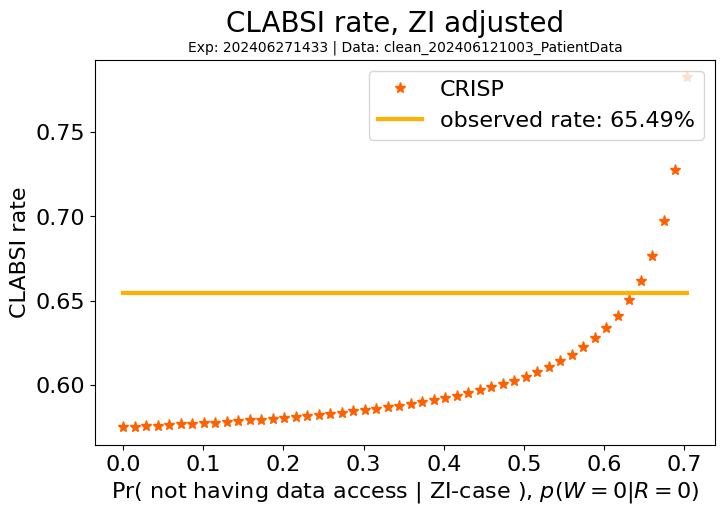

In [25]:
# plot sensitivity-analysis curve

output_name = f"202406271433-crisp"

plt.figure(figsize=(8,5))

plt.plot(p_w0_r0s_em_c, p_x11s_em_c, "*", c='#FE6100', lw=1, ms=8, label="CRISP")
all_p_w0_r0s = p_w0_r0s_em_c
observed_rate = np.sum(p_WXC_emp.to_numpy().reshape(2,2,-1), axis=(0,2))[1]
plt.plot([np.min(all_p_w0_r0s), np.max(all_p_w0_r0s)], np.ones(2)*observed_rate, "-", c="#FFB000", lw=3, label=f"observed rate: {observed_rate*100:.2f}%")

plt.rcParams.update({'font.size': 16})

plt.xlabel("Pr( not having data access | ZI-case ), $p(W=0|R=0)$", fontsize=16) #, fontweight='bold')
plt.ylabel("CLABSI rate", fontsize=16)
plt.legend(loc="upper right", fontsize=16)
plt.suptitle("CLABSI rate, ZI adjusted", fontsize=20)
plt.title("Exp: 202406271433 | Data: clean_202406121003_PatientData", fontsize=10)
plt.savefig(f'{output_name}.jpeg')

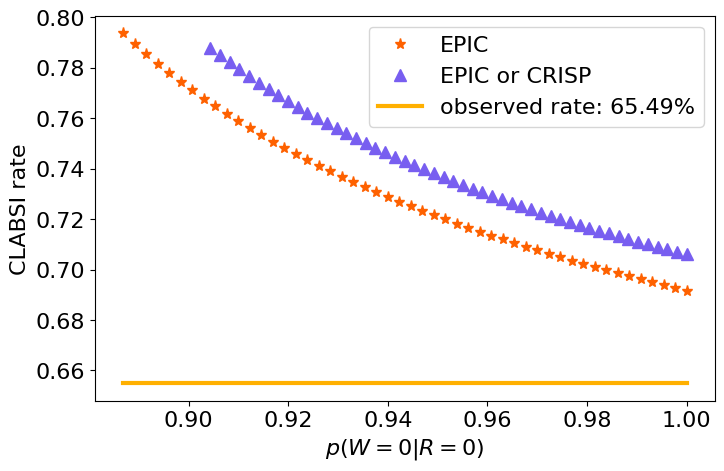

In [17]:
# plot sensitivity-analysis curve

output_name = f"202406271433-epic_vs_eoc"

plt.figure(figsize=(8,5))

plt.plot(p_w0_r0s_em_e, p_x11s_em_e, "*", c='#FE6100', lw=1, ms=8, label="EPIC")            # EHRS is EPIC, for blind submission version
plt.plot(p_w0_r0s_em_mix, p_x11s_em_mix, "^", c='#785EF0', lw=1, ms=8, label="EPIC or CRISP") # HIE is CRIPS, for blind submission version
all_p_w0_r0s = p_w0_r0s_em_e
observed_rate = np.sum(p_WXC_emp.to_numpy().reshape(2,2,-1), axis=(0,2))[1]
plt.plot([np.min(all_p_w0_r0s), np.max(all_p_w0_r0s)], np.ones(2)*observed_rate, "-", c="#FFB000", lw=3, label=f"observed rate: {observed_rate*100:.2f}%")

plt.rcParams.update({'font.size': 16})

plt.xlabel("$p(W=0|R=0)$", fontsize=16)

# plt.xlabel("Pr( not having data access | ZI-case ), $p(W=0|R=0)$", fontsize=16) #, fontweight='bold')
plt.ylabel("CLABSI rate", fontsize=16)
plt.legend(loc="upper right", fontsize=16)
# plt.suptitle("CLABSI rate, ZI adjusted", fontsize=20)
# plt.title("Exp: 202406271433 | Data: clean_202406121003_PatientData", fontsize=10)
# plt.savefig(f'{output_name}.jpeg')
plt.savefig('UAI_clabsi_202406271433.jpeg')

### Comparison: ZI MAR with C -> W

In [17]:
W = "EPIC"
output_name = f"202406271433-{W.lower()}"
df = pd.read_csv(f"p_wxc-CtoW-{output_name}.csv")
p_WXC_em_e = deepcopy(df["em_zar"])

p_WXC = p_WXC_em_e.to_numpy().reshape(2,2,-1)

In the functions `get_bounds_2` and `calc_rate_2`, we calc bounds and rate for only C values in the support of $p(C)$.
For the other $c$ not in the support, we have $p(W=0,X,c) = p(W=1,X,c) = 0$, and by convention we let $p(W=0 \mid X,c) = 0$, and zero-inflation doesn't occur (see theorem). For those $c$, $p(R=1,X,c) = p(X,c) = 0$, and they do not contribute to the rate.

In [52]:
p_w0_r1_em_e, analytic_lb_em_e, analytic_ub_em_e = get_bounds_2(p_WXC, C_vals)

p(w0|r1) is identfied = 0.5707480208206736.
Bounds: 0.7432780975724472 < p(w0|r0) < 1.
p(w0|r1) is identfied = 0.3792901740593016.
Bounds: 0.8932537707015958 < p(w0|r0) < 1.
p(w0|r1) is identfied = 0.6822881361537629.
Bounds: 0.9216601475636907 < p(w0|r0) < 1.
p(w0|r1) is identfied = 0.48323924688794295.
Bounds: 0.5883634824544904 < p(w0|r0) < 1.
p(w0|r1) is identfied = 0.7731866996604647.
Bounds: 0 < p(w0|r0) < 0.7287008541873615.
p(w0|r1) is identfied = 0.883393383971868.
Bounds: 0 < p(w0|r0) < 0.543521945050434.
p(w0|r1) is identfied = 0.5054048152691807.
Bounds: 0.9764946168146661 < p(w0|r0) < 1.
p(w0|r1) is identfied = 0.8823719563316398.
Bounds: 0.9855965714212392 < p(w0|r0) < 1.
p(w0|r1) is identfied = 0.6721221298185511.
Bounds: 0.9766582127934926 < p(w0|r0) < 1.
p(w0|r1) is identfied = 0.030002097246916486.
Bounds: 0.49998130981970984 < p(w0|r0) < 1.
p(w0|r1) is identfied = 0.9766645832906984.
Bounds: 0 < p(w0|r0) < 0.500063819425955.
p(w0|r1) is identfied = 0.4234236020552486

In [54]:
p_x11s_em_e, _ = calc_rate_2(p_WXC, p_w0_r1_em_e, analytic_lb_em_e, analytic_ub_em_e, C_vals)
print(f"Adjusted CLABSI rate: min = {np.min(p_x11s_em_e)}, max = {np.max(p_x11s_em_e)}")

Adjusted CLABSI rate: min = 0.7723412953411278, max = 0.930411234154292


In [48]:
# Covariates of narrowest bounds
np.asarray(C)[np.asarray(C_vals[34]) == 1]

array(['OPAT', 'PICC'], dtype='<U12')

In [49]:
# Covariates of widest bounds
np.asarray(C)[np.asarray(C_vals[193]) == 1]

array(['Peds', 'Chemotherapy', 'TunneledCVC'], dtype='<U12')